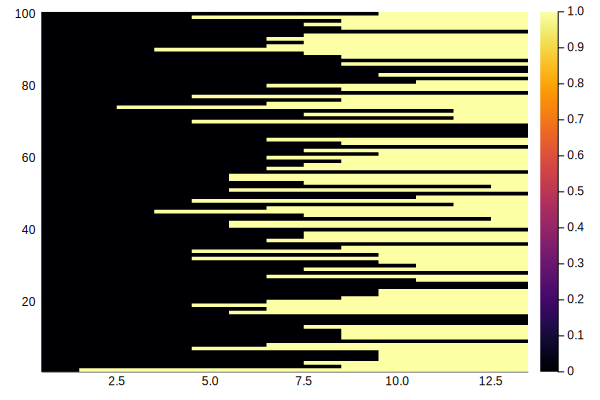

In [15]:
using Plots, Distributions
import Base.Iterators: countfrom
 
function SIR_simulation(population_size, infection_probability)
    statuses = fill("susceptible", population_size, 1)
    statuses[1, 1] = "infectious"
    for t in countfrom(2)
        n_infectious = sum(statuses[:, t-1] .== "infectious")
        if n_infectious == 0
            break
        end
        statuses = [statuses fill("susceptible", population_size)]
        for k in 1:population_size
            if statuses[k, t-1] == "susceptible"
                if rand() < 1 - (1 - infection_probability)^n_infectious
                    statuses[k, t] = "infectious"
                end
            else
                statuses[k, t] = "recovered"
            end
        end
    end
    statuses
end
 
population_size = 100
infection_probability = 2 / population_size
statuses = SIR_simulation(population_size, infection_probability)
heatmap(statuses .== "recovered")

Experiment with the value in the numerator of the second line below (which starts out at 1.0): 

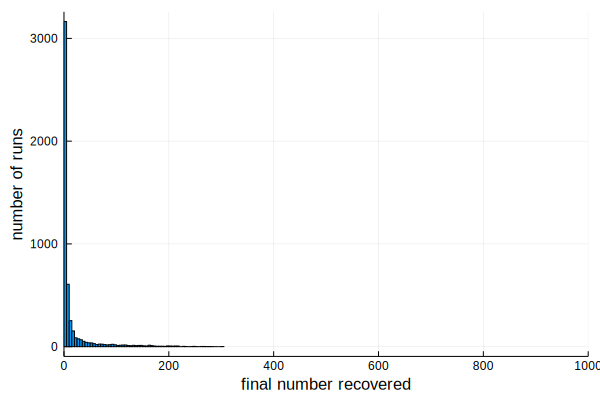

In [16]:
n = population_size = 1000
p = infection_probability = 1.0/population_size
n_recovered(n, p) = sum(SIR_simulation(n, p)[:, end] .== "recovered")
histogram([n_recovered(n, p) for _ in 1:5_000], xlims = (0, 1000), 
          nbins = 100, label = "", xlabel = "final number recovered",
          ylabel = "number of runs")

The graph below shows the approximate proportion of the population eventually infected, in the event of an outbreak

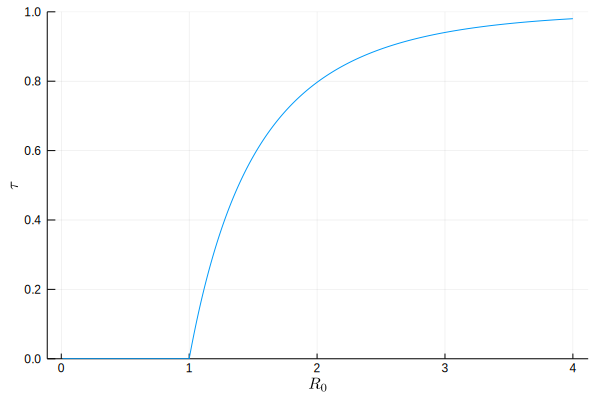

In [17]:
using Roots, Plots
plot(0.01:0.01:4, 
     R₀ -> find_zero(τ -> 1 - τ - exp(-R₀*τ), 0.5), 
     label = "", xlabel = "R0", ylabel = "tau", 
     ylims = (0,1))

Flattening the curve:

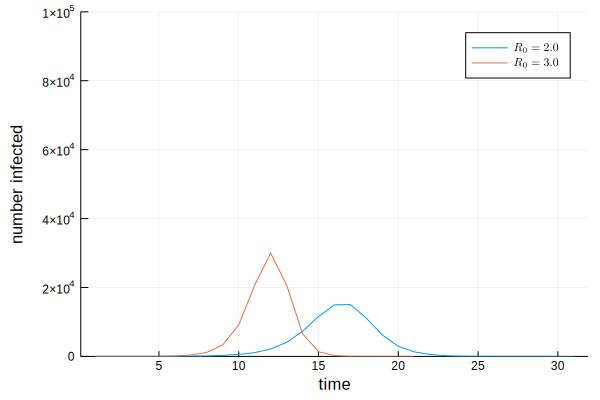

In [18]:
function infection_curve!(R₀)
    population_size = 100_000
    infection_probability = R₀/population_size
    statuses = SIR_simulation(population_size, infection_probability)
    plot!(sum(statuses .== "infectious", dims = 1)[:], label = latexstring("R_0 = $(R₀)"), xlabel = "time", 
            ylabel = "number infected", ylims = (0,population_size))
end
 
using Random; Random.seed!(1)
plot()
infection_curve!(2.0)
infection_curve!(3.0)

What happens if you start with more than 1 initially infected individual:

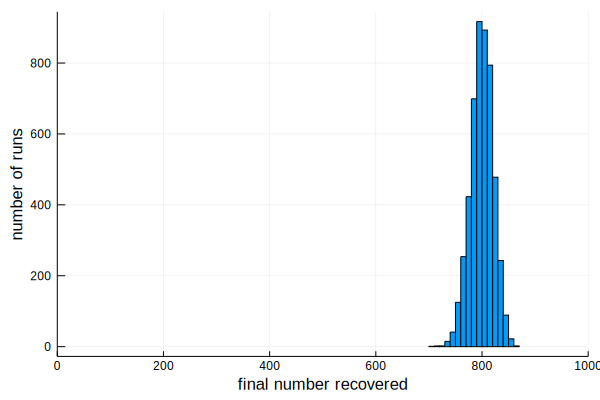

In [19]:
using Plots
import Base.Iterators: countfrom
 
function SIR_simulation(population_size, infection_probability, n_initially_infected)
    statuses = fill("susceptible", population_size, 1)
    statuses[1:n_initially_infected, 1] .= "infectious"
    for t in countfrom(2)
        n_infectious = sum(statuses[:, t-1] .== "infectious")
        if n_infectious == 0
            break
        end
        statuses = [statuses fill("susceptible", population_size)]
        for k in 1:population_size
            if statuses[k, t-1] == "susceptible"
                if rand() < 1 - (1 - infection_probability)^n_infectious
                    statuses[k, t] = "infectious"
                end
            else
                statuses[k, t] = "recovered"
            end
        end
    end
    statuses
end
 
n = population_size = 1000
p = infection_probability = 2/population_size
n_recovered(n, p) = sum(SIR_simulation(n, p, 10)[:, end] .== "recovered")
histogram([n_recovered(n, p) for _ in 1:5_000], xlims = (0, 1000), 
          nbins = 20, label = "", xlabel = "final number recovered",
          ylabel = "number of runs")

A spatial version of the model: 

In [20]:
using Plots
 
"Return the four nodes adjacent to (i,j)"
function neighbors(i, j, sidelength, barrier = Set())
    filter(k -> all(1 .≤ k .≤ sidelength) && k ∉ barrier, [(i+1, j), (i-1, j), (i, j+1), (i, j-1)])
end
 
function spatial_simulation(sidelength, n_timesteps, R₀, barrier = Set())
    statuses = fill("susceptible", sidelength, sidelength, n_timesteps)
    statuses[1:3, 1:3, 1] .= "infectious"
    for t in 2:n_timesteps
        for i in 1:sidelength
            for j in 1:sidelength
                if statuses[i, j, t - 1] == "infectious"
                    nbs = neighbors(i, j, sidelength, barrier)
                    for (k,l) in nbs
                        if statuses[k, l, t-1] == "susceptible"
                            if rand() < R₀/length(nbs)
                                statuses[k, l, t] = "infectious"
                            end
                        end
                    end
                    statuses[i, j, t] = "recovered"
                elseif statuses[i, j, t - 1] == "recovered"
                    statuses[i, j, t] = "recovered"
                end
            end
        end
    end
    statuses
end

function infection_plot(statuses)
    p = plot(ratio = 1, legend = false, axis = false, grid = false)
    for (status, color) in (("susceptible", "gray"), 
                            ("infectious", "tomato"), 
                            ("recovered", "darkgreen"))
        pts = [Tuple(i) for i in CartesianIndices(statuses) if statuses[i] == status]
        if length(pts) > 0
            scatter!(p, pts, color = color, markersize = 6)
        end
    end
    p
end 

infection_plot (generic function with 1 method)

In [21]:
sidelength = 30
n_timesteps = 150
barrier_height = 25
barrier = Set([(10, k) for k in 1:barrier_height])
R₀ = 2.2
statuses = spatial_simulation(30, 150, R₀, barrier);

In [22]:
using Interact
# this cell should give you a slider for interacting with the graphic
# if it doesn't work, use the next one
@manipulate for t in 1:n_timesteps
    infection_plot(statuses[:, :, t])
    scatter!(collect(barrier), color = :black, markershape = :square)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["t"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 150,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
75, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/sswatson/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/sswatson/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/sswatson/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/sswatson/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/sswatson/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000013043b190, Task (runnable) @0x000000013043b190), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"3

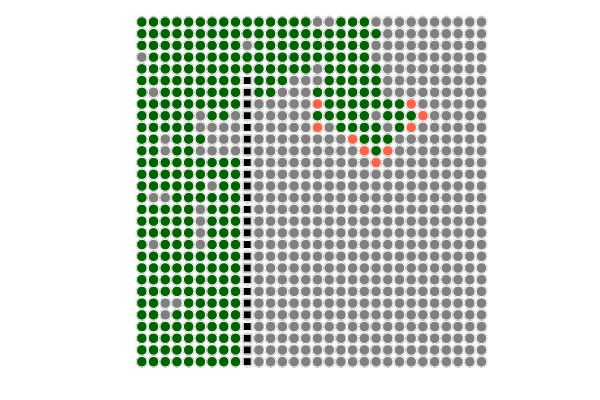

In [26]:
infection_plot(statuses[:, :, 60])
scatter!(collect(barrier), color = :black, markershape = :square)